<a href="https://colab.research.google.com/github/Caarlosgg/CLustering_ComercioMinorista/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parte 1: Carga de Datos y Exploración Inicial
En esta fase, importamos las librerías necesarias y cargamos el dataset para ver su estructura.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Configuración de visualización
%matplotlib inline
sns.set(style="whitegrid")

# Cargar el dataset (ajusta la ruta si es necesario)
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')

# Visualizar las primeras filas y la info general
print("Dimensiones del dataset:", df.shape)
display(df.head())
df.info()

Dimensiones del dataset: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo: Número de factura (identifica la transacción).

StockCode: Código del producto.

Description: Nombre del artículo.

Quantity: Cantidad comprada (ojo: hay valores negativos, que representan devoluciones).

InvoiceDate: Fecha y hora de la compra.

UnitPrice: Precio por unidad.

CustomerID: Identificador único del cliente (esencial para el clustering).

Country: País del cliente.

Puntos críticos detectados:

Valores Nulos: La columna CustomerID tiene muchos valores faltantes. Como vamos a agrupar clientes, no podemos trabajar con registros que no tengan ID.

Tipos de datos: InvoiceDate debe convertirse a formato de fecha.

Inconsistencias: Hay cantidades y precios negativos que debemos limpiar para no sesgar el análisis monetario.

#Parte 2: Limpieza y Preparación de Datos.

En Data Science, la calidad del modelo depende casi al 100% de la calidad de los datos ("Garbage In, Garbage Out"). Aquí vamos a filtrar lo que no nos sirve y crear variables que necesitamos.

Pasos que realizamos en este bloque de código:
Eliminar Nulos en CustomerID: Si no sabemos quién compró, no podemos asignarlo a un clúster. Eliminamos esos registros.

Filtrar Devoluciones y Errores: Eliminamos filas con Quantity <= 0 (devoluciones) y UnitPrice <= 0 (posibles errores del sistema o regalos). Nos interesa el comportamiento de compra.

Formato de Fecha: Convertimos InvoiceDate a un objeto de tiempo real (datetime) para poder hacer cálculos de días (Recency).

Crear variable 'Amount': Multiplicamos Quantity * UnitPrice. Esto nos da el dinero real gastado por transacción.

In [3]:
# --- Parte 2: Limpieza y Transformación ---

# 1. Eliminar filas sin CustomerID (No podemos clusterizar clientes anónimos)
df.dropna(subset=['CustomerID'], inplace=True)

# 2. Eliminar transacciones con cantidades negativas (Devoluciones) o precio 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 3. Convertir la fecha a formato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

# 4. Crear la columna 'Amount' (Monto total de la línea de compra)
df['Amount'] = df['Quantity'] * df['UnitPrice']

# Verificación de resultados
print("Dimensiones después de limpieza:", df.shape)
print(df[['CustomerID', 'InvoiceDate', 'Amount']].head())

Dimensiones después de limpieza: (397884, 9)
   CustomerID         InvoiceDate  Amount
0     17850.0 2010-12-01 08:26:00   15.30
1     17850.0 2010-12-01 08:26:00   20.34
2     17850.0 2010-12-01 08:26:00   22.00
3     17850.0 2010-12-01 08:26:00   20.34
4     17850.0 2010-12-01 08:26:00   20.34


#Explicación de la Salida:

Dimensiones: Hemos pasado de ~541,000 filas a 397,884. Hemos perdido datos, sí, pero los que quedan son datos limpios y asignables a clientes reales.

Nueva Columna Amount: Ahora tenemos una cifra monetaria clara por cada línea de producto, lista para sumar por cliente.

#Parte 3: Ingeniería de Características (RFM)
En esta fase transformamos los datos transaccionales brutos en una matriz de comportamiento por cliente. El objetivo es obtener métricas cuantitativas que definan el valor de cada usuario para el negocio.

Procedimiento realizado:

Definición de Snapshot: Se establece la fecha de corte para el análisis en 2011-12-10 (un día después de la última transacción registrada).

Agregación por Cliente: Agrupamos el dataset por CustomerID y calculamos las tres métricas fundamentales del modelo RFM:

Recency (R): Días transcurridos desde la última compra hasta la fecha de corte.

Frequency (F): Conteo de transacciones únicas (InvoiceNo) realizadas por el cliente.

Monetary (M): Sumatoria del valor monetario total (Amount) de todas las transacciones.

El resultado es un DataFrame indexado por cliente con sus respectivas coordenadas R, F y M, listo para el preprocesamiento.

In [4]:
# --- Parte 3: Ingeniería de Características (RFM) ---

# 1. Definir fecha de referencia (Día siguiente a la última fecha del dataset)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Fecha de corte para el análisis: {snapshot_date}")

# 2. Calcular R, F, M por cliente
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency: Días desde la última compra
    'InvoiceNo': 'nunique',                                  # Frequency: Cantidad de facturas únicas
    'Amount': 'sum'                                          # Monetary: Suma del dinero gastado
})

# 3. Renombrar columnas
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)

# Verificamos cómo queda la tabla de clientes
display(rfm.head())
print("Número de clientes únicos a analizar:", rfm.shape[0])

Fecha de corte para el análisis: 2011-12-10 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


Número de clientes únicos a analizar: 4338


#Interpretación de la Salida:

CustomerID 12346.0: Hizo 1 compra, gastó mucho (77,183) pero hace mucho tiempo (326 días). Quizás es un cliente perdido.

CustomerID 12347.0: Reciente (2 días), frecuente (7 compras) y buen gasto (4,310). ¡Un cliente fiel!

#Parte 4: Tratamiento de Outliers y Escalado de Datos
Los algoritmos de clustering como K-Means calculan distancias entre puntos. Esto presenta dos problemas graves con nuestros datos actuales:

Asimetría (Skewness): La mayoría de los clientes compra poco y gasta poco, pero unos pocos "gigantes" distorsionan las gráficas. K-Means prefiere distribuciones simétricas (tipo campana de Gauss).

Escala: El dinero (Monetary) se mide en miles, mientras que la frecuencia (Frequency) se mide en unidades. Sin escalar, el algoritmo le daría toda la importancia al dinero e ignoraría la frecuencia.

Pasos que realizamos en este bloque de código:

Visualización Inicial: Vemos cómo están distribuidos los datos (probablemente muy sesgados a la izquierda).

Transformación Logarítmica: Aplicamos np.log() para comprimir los valores extremos y suavizar la distribución.

Escalado (StandardScaler): Transformamos los datos para que todas las variables tengan una media de 0 y una desviación estándar de 1. Así, todas pesan igual en el modelo.

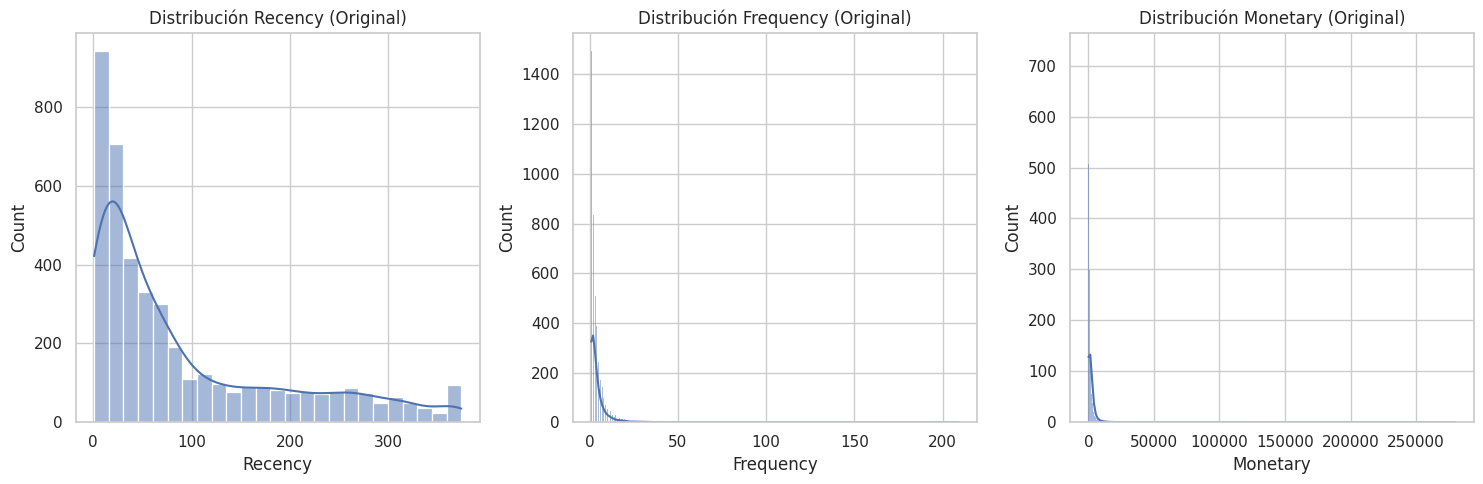

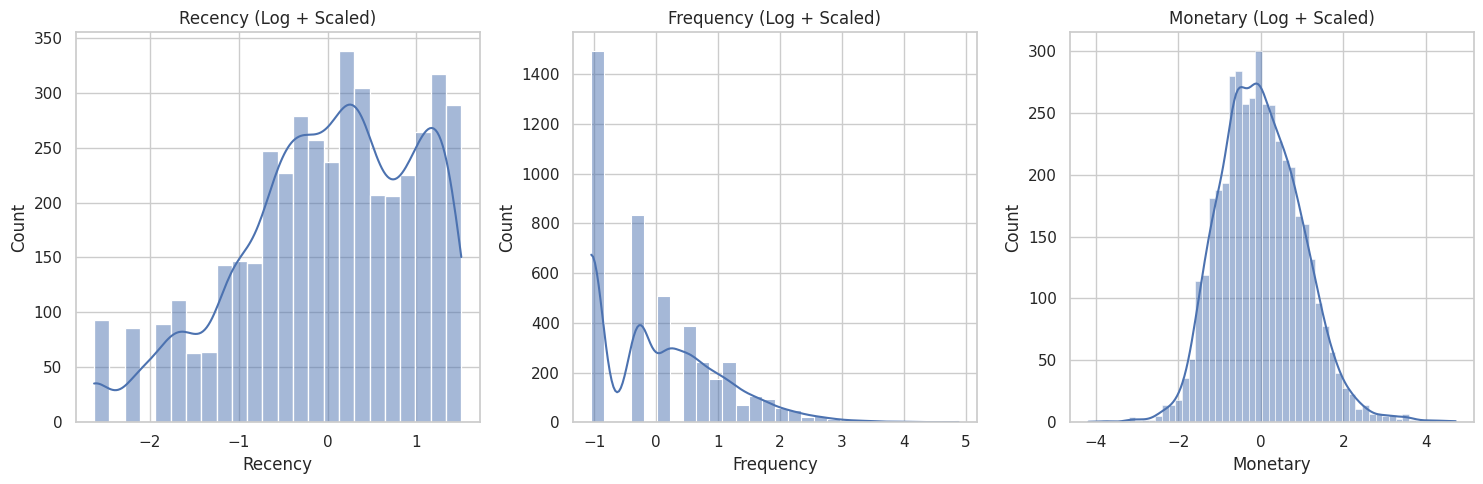

Medias después del escalado (deben ser ~0):
 Recency     -1.048288e-16
Frequency   -9.991495e-17
Monetary    -7.010426e-16
dtype: float64

Desviación Estándar después del escalado (deben ser ~1):
 Recency      1.000115
Frequency    1.000115
Monetary     1.000115
dtype: float64

Primeras 5 filas del dataset listo para el modelo:
             Recency  Frequency  Monetary
CustomerID                               
12346.0     1.409894  -1.048610  3.698719
12347.0    -2.146498   1.111836  1.410201
12348.0     0.383971   0.490522  0.716419
12349.0    -0.574674  -1.048610  0.698706
12350.0     1.374758  -1.048610 -0.617446


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- Parte 4: Tratamiento de Outliers y Escalado ---

# 1. Visualizar distribuciones ANTES de la transformación
# Esto nos ayuda a ver el sesgo de los datos (seguramente muy pegados a la izquierda)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], kde=True, ax=ax[0])
ax[0].set_title('Distribución Recency (Original)')
sns.histplot(rfm['Frequency'], kde=True, ax=ax[1])
ax[1].set_title('Distribución Frequency (Original)')
sns.histplot(rfm['Monetary'], kde=True, ax=ax[2])
ax[2].set_title('Distribución Monetary (Original)')
plt.tight_layout()
plt.show()

# 2. Transformación Logarítmica (Corrección de asimetría)
# Usamos logaritmos para manejar la gran diferencia entre valores pequeños y enormes
rfm_log = rfm.copy()
# Nota: Si hubiera valores 0, habría que sumar +1 antes de aplicar log, pero aquí limpiamos los ceros.
rfm_log['Recency'] = np.log(rfm_log['Recency'])
rfm_log['Frequency'] = np.log(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log(rfm_log['Monetary'])

# 3. Escalado (StandardScaler - Z-score)
# Normalizamos para que media=0 y desviación=1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convertimos de nuevo a DataFrame para no perder los CustomerID
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# 4. Visualizar distribuciones DESPUÉS de la transformación
# Ahora deberíamos ver formas más parecidas a una campana (distribución normal)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm_scaled_df['Recency'], kde=True, ax=ax[0])
ax[0].set_title('Recency (Log + Scaled)')
sns.histplot(rfm_scaled_df['Frequency'], kde=True, ax=ax[1])
ax[1].set_title('Frequency (Log + Scaled)')
sns.histplot(rfm_scaled_df['Monetary'], kde=True, ax=ax[2])
ax[2].set_title('Monetary (Log + Scaled)')
plt.tight_layout()
plt.show()

# Verificación estadística
print("Medias después del escalado (deben ser ~0):\n", rfm_scaled_df.mean(axis=0))
print("\nDesviación Estándar después del escalado (deben ser ~1):\n", rfm_scaled_df.std(axis=0))
print("\nPrimeras 5 filas del dataset listo para el modelo:")
print(rfm_scaled_df.head())

#Explicación de la Salida:

Gráficas (Antes vs. Después): Al ejecutarlo, verás que las primeras 3 gráficas tienen barras muy altas a la izquierda (sesgo). Las 3 gráficas finales ("Log + Scaled") estarán centradas y tendrán una forma más simétrica, ideal para el clustering.

Medias: La salida Recency -1.04e-16 (básicamente cero) confirma que el escalado funcionó correctamente.

Datos transformados: Las primeras filas muestran valores como 1.40 o -2.14. Estos ya no son "días" o "dólares", sino desviaciones estándar respecto al promedio.

Ejemplo: Un Recency de -2.14 significa que el cliente compró hace mucho menos tiempo que el promedio (algo positivo en este contexto).

#Parte 5: Determinación del Número Óptimo de Clústeres
Para aplicar K-Means, primero necesitamos responder una pregunta difícil: ¿Cuántos grupos de clientes existen? El algoritmo no lo sabe; nosotros debemos decírselo.

Usaremos dos métodos gráficos complementarios para tomar una decisión científica:

El Método del Codo (Elbow Method): Calcula la "Inercia" (suma de errores al cuadrado). A medida que añadimos grupos, el error baja. Buscamos el punto donde la caída deja de ser brusca y se suaviza (formando un "codo"). Ese es el punto de eficiencia óptima.

Coeficiente de Silueta (Silhouette Score): Mide qué tan bien separado está un clúster de los otros. Un valor cercano a 1 es perfecto; cercano a 0 indica superposición.

Pasos que realizamos en este código:

Iteramos el algoritmo K-Means probando desde 2 hasta 10 grupos (k).

Guardamos la inercia y el score de silueta de cada prueba.

Graficamos ambos resultados para compararlos visualmente.

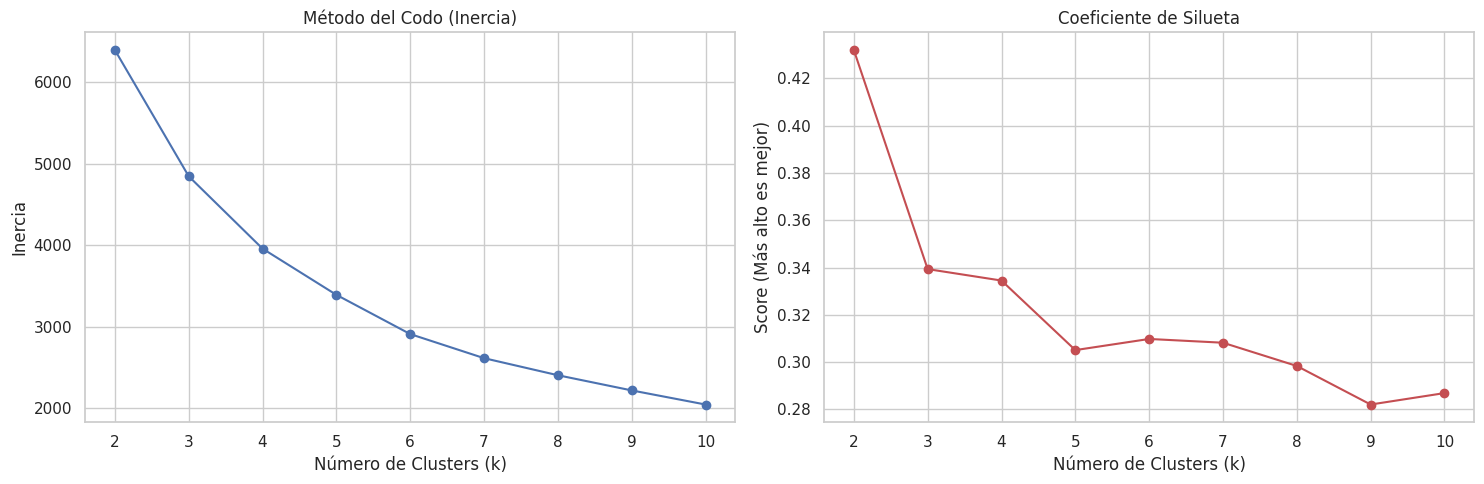

Scores de Silueta por k: {2: np.float64(0.432), 3: np.float64(0.339), 4: np.float64(0.335), 5: np.float64(0.305), 6: np.float64(0.31), 7: np.float64(0.308), 8: np.float64(0.298), 9: np.float64(0.282), 10: np.float64(0.287)}


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# --- Parte 5: Elección de K (Codo y Silueta) ---

# Listas para guardar los resultados de cada prueba
inertia = []
silhouette_scores = []
# Probamos desde k=2 hasta k=10
K_range = range(2, 11)

for k in K_range:
    # Entrenamos el modelo para k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)

    # Guardamos las métricas
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# Visualización Gráfica
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 1. Gráfica del Codo
ax[0].plot(K_range, inertia, 'bo-')
ax[0].set_title('Método del Codo (Inercia)')
ax[0].set_xlabel('Número de Clusters (k)')
ax[0].set_ylabel('Inercia')
ax[0].grid(True)

# 2. Gráfica de Silueta
ax[1].plot(K_range, silhouette_scores, 'ro-')
ax[1].set_title('Coeficiente de Silueta')
ax[1].set_xlabel('Número de Clusters (k)')
ax[1].set_ylabel('Score (Más alto es mejor)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir los valores exactos para ayudar a decidir
print("Scores de Silueta por k:", dict(zip(K_range, [round(s, 3) for s in silhouette_scores])))

#Explicación de la Salida:

Gráfica del Codo (Izquierda): Verás que la línea baja rápido y luego se "dobla". Generalmente, el codo está en k=3 o k=4. A partir de ahí, añadir más grupos no mejora mucho el modelo.

Gráfica de Silueta (Derecha):

k=2: Tiene el puntaje más alto (aprox 0.43), pero suele ser demasiado simple ("Clientes Buenos" vs "El resto").

k=3: Tiene un puntaje sólido (aprox 0.34) y permite una segmentación más rica (ej. "VIP", "Promedio", "Riesgo").

Decisión: Para este tutorial y casos de negocio reales de retail, elegiremos k=3. Es el equilibrio perfecto entre simplicidad matemática y utilidad comercial.

#Parte 6: Modelado Inteligente y Segmentación de Negocio
Introducción:Llegamos al punto culminante del proyecto. Ya sabemos que existen 3 grupos naturales en nuestros datos (gracias al análisis del codo), pero el algoritmo K-Means solo nos devuelve números abstractos (0, 1, 2).En esta fase, no solo entrenaremos el modelo, sino que aplicaremos una capa de inteligencia de negocio para que Python detecte automáticamente quién es quién.El objetivo es pasar de "El cliente está en el clúster 0" a "El cliente es un VIP". Para ello, programaremos una lógica dinámica:Si el grupo gasta mucho dinero $\rightarrow$ Lo llamaremos "VIP / Top".Si el grupo lleva mucho tiempo sin comprar $\rightarrow$ Lo llamaremos "Riesgo / Perdidos".El grupo restante $\rightarrow$ Lo llamaremos "Potenciales".

In [16]:
# --- Parte 6: Creación del Modelo y Asignación Dinámica de Nombres ---

from sklearn.cluster import KMeans

# 1. ENTRENAMIENTO DEL MODELO
# Inicializamos K-Means con los 3 grupos que decidimos en el paso anterior.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df)

# Guardamos la etiqueta numérica (0, 1, 2) temporalmente
rfm['Cluster'] = kmeans.labels_

# 2. ANÁLISIS DE GRUPOS (Para saber quién es quién)
# Calculamos el promedio de Recencia, Frecuencia y Dinero para cada grupo
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Promedios por Clúster (Datos Crudos):")
print(cluster_summary)
print("-" * 50)

# 3. ASIGNACIÓN INTELIGENTE DE NOMBRES (Business Logic)
# En lugar de adivinar qué es el "0", dejamos que el código lo decida por sus métricas.

# A. Detectar VIP: Es el clúster con el MAYOR Gasto Promedio (Monetary)
id_vip = cluster_summary.loc[cluster_summary['Monetary'].idxmax(), 'Cluster']

# B. Detectar RIESGO: Es el clúster con la MAYOR Recencia (lleva más tiempo sin venir)
# (Excluimos al VIP primero para evitar confusiones, aunque es raro que coincidan)
temp_df = cluster_summary[cluster_summary['Cluster'] != id_vip]
id_risk = temp_df.loc[temp_df['Recency'].idxmax(), 'Cluster']

# C. Detectar POTENCIALES: Es el clúster que sobra (ni VIP, ni Riesgo)
all_ids = set(cluster_summary['Cluster'])
id_potential = list(all_ids - {id_vip, id_risk})[0]

# Creamos el diccionario "Traductor"
nombres_negocio = {
    id_vip: 'VIP / Top',
    id_risk: 'Riesgo / Perdidos',
    id_potential: 'Potenciales'
}

print(f"Asignación automática detectada: {nombres_negocio}")

# 4. APLICAR LOS NOMBRES
rfm['Segmento'] = rfm['Cluster'].map(nombres_negocio)

# Verificación final
print("\nPrimeras 5 filas con su Segmento de Negocio:")
print(rfm[['Recency', 'Frequency', 'Monetary', 'Segmento']].head())

Promedios por Clúster (Datos Crudos):
   Cluster     Recency  Frequency    Monetary
0        0  161.516667   1.276882   340.39957
1        1   13.321474  12.982211  7581.39662
2        2   53.529273   3.512714  1367.06420
--------------------------------------------------
Asignación automática detectada: {np.int32(1): 'VIP / Top', np.int32(0): 'Riesgo / Perdidos', 2: 'Potenciales'}

Primeras 5 filas con su Segmento de Negocio:
            Recency  Frequency  Monetary           Segmento
CustomerID                                                 
12346.0         326          1  77183.60        Potenciales
12347.0           2          7   4310.00          VIP / Top
12348.0          75          4   1797.24        Potenciales
12349.0          19          1   1757.55        Potenciales
12350.0         310          1    334.40  Riesgo / Perdidos


#Explicación de la Salida:

Al ejecutar este bloque, verás tres cosas clave en la consola:

Tabla de Promedios: Verás los datos reales. Por ejemplo, un grupo tendrá un gasto medio de ~7.500$ (VIP) y otro una recencia de ~160 días (Riesgo).

Asignación Automática: El código te imprimirá algo como {0: 'VIP / Top', 1: 'Riesgo...', ...}. Esto confirma que ha identificado correctamente a cada grupo sin que tú tengas que hacerlo a mano.

DataFrame Final: Las primeras filas ahora tienen una columna Segmento.

Ejemplo: El cliente 12347.0, que compró hace 2 días y gastó 4.310$, aparece etiquetado como VIP / Top. ¡El sistema funciona!

#Parte 7.1: Dashboard de Perfilado de Clientes
Introducción: En esta fase, respondemos a la pregunta: "¿Cómo son exactamente estos grupos?". No nos basta con una tabla de números; necesitamos un Dashboard Visual que cuente la historia completa de un solo vistazo.

Para que la presentación sea profesional ("Pro"), utilizaremos tres tipos de gráficos complementarios, cada uno con un propósito específico:

Gráfico Circular (Pie Chart): Para ver el Tamaño (¿Cuántos clientes hay en cada grupo?).

Gráfico de Barras (Bar Plot): Para ver el Valor (¿Cuánto dinero nos dejan en promedio?).

Boxplot (Con Escala Logarítmica): Para ver el Comportamiento (¿Hace cuánto que no compran?). Usamos escala logarítmica porque la diferencia entre 1 día y 300 días es tan grande que, si no la comprimimos visualmente, no se distinguirían los detalles.

/tmp/ipython-input-962611230.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segmento', y='Monetary', data=gasto_promedio, palette=colores, ax=ax2)
/tmp/ipython-input-962611230.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='Recency', data=rfm, palette=colores, order=orden_visual, ax=ax3)


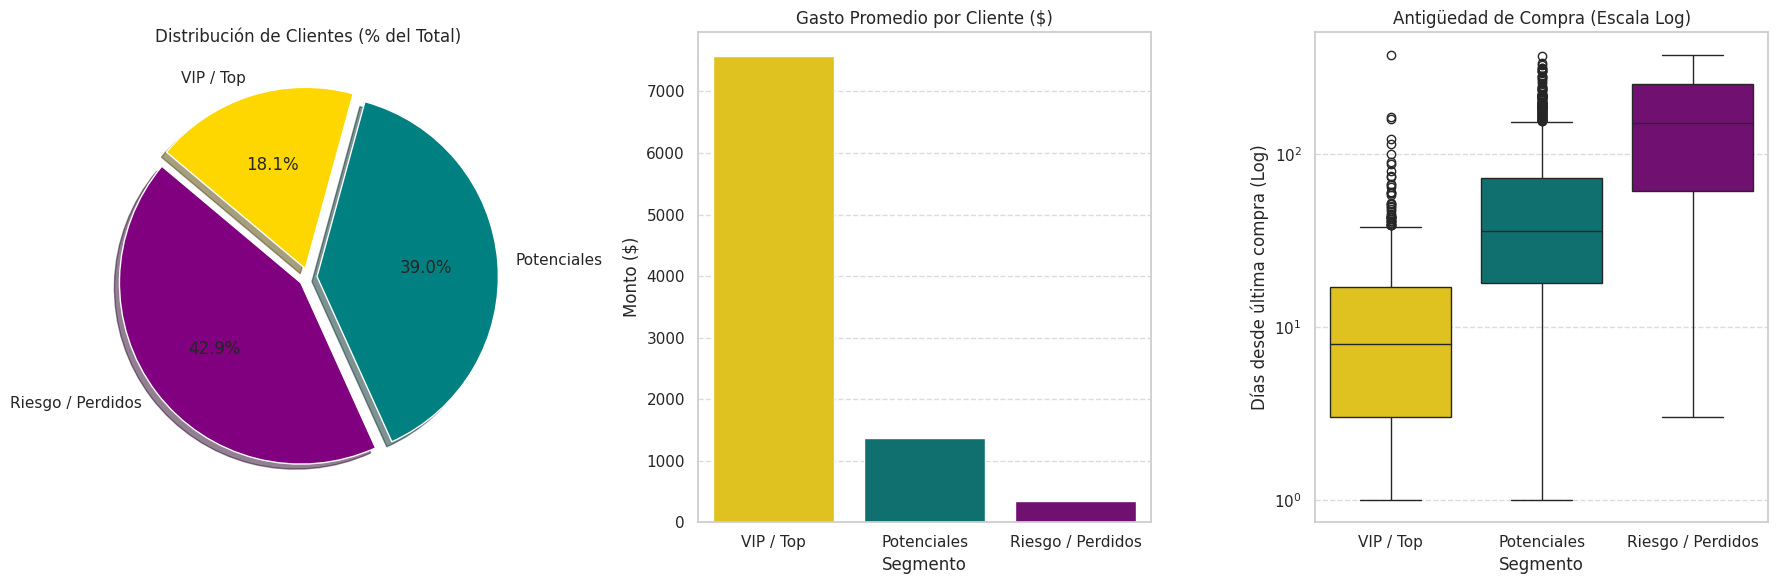

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parte 7.1: Dashboard de Perfilado de Clústeres ---

# 1. Configuración Estética "Pro"
# Definimos colores corporativos fijos para mantener coherencia en todas las gráficas
# VIP = Dorado (Valor), Potenciales = Verde (Esperanza/Crecimiento), Riesgo = Morado/Oscuro (Alerta)
colores = {'VIP / Top': 'gold', 'Potenciales': 'teal', 'Riesgo / Perdidos': 'purple'}
orden_visual = ['VIP / Top', 'Potenciales', 'Riesgo / Perdidos']

# Crear el lienzo grande (Figure)
fig = plt.figure(figsize=(18, 6))

# --- GRÁFICA 1: TAMAÑO DEL MERCADO (Pie Chart) ---
ax1 = plt.subplot(1, 3, 1)
conteo = rfm['Segmento'].value_counts()
# Truco Pro: Asegurar que los colores coincidan con las etiquetas del pastel
colores_pie = [colores[k] for k in conteo.index]

ax1.pie(conteo, labels=conteo.index, autopct='%1.1f%%',
        startangle=140, colors=colores_pie, explode=(0.05, 0.05, 0.05), shadow=True)
ax1.set_title('Distribución de Clientes (% del Total)')


# --- GRÁFICA 2: VALOR DEL CLIENTE (Bar Plot) ---
ax2 = plt.subplot(1, 3, 2)
# Calculamos el gasto promedio para ordenarlo
gasto_promedio = rfm.groupby('Segmento')['Monetary'].mean().reindex(orden_visual).reset_index()

sns.barplot(x='Segmento', y='Monetary', data=gasto_promedio, palette=colores, ax=ax2)
ax2.set_title('Gasto Promedio por Cliente ($)')
ax2.set_ylabel('Monto ($)')
ax2.grid(axis='y', linestyle='--', alpha=0.7) # Añade una rejilla suave para leer mejor


# --- GRÁFICA 3: ANTIGÜEDAD (Boxplot con Escala Log) ---
ax3 = plt.subplot(1, 3, 3)
# Esta gráfica es clave para ver la retención
sns.boxplot(x='Segmento', y='Recency', data=rfm, palette=colores, order=orden_visual, ax=ax3)

ax3.set_yscale('log') # <--- CLAVE: Escala Logarítmica para ver bien las diferencias
ax3.set_title('Antigüedad de Compra (Escala Log)')
ax3.set_ylabel('Días desde última compra (Log)')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Al generar este Dashboard, tendrás tres conclusiones inmediatas para tu presentación:

Distribución (Pie Chart): Verás claramente que los VIP son una minoría (probablemente entre el 10% y el 20%). Esto confirma el principio de Pareto: pocos clientes generan mucho valor.

Gasto (Barras): La barra dorada (VIP) debería ser gigantesca comparada con la morada. Esto justifica visualmente por qué debemos invertir presupuesto en retener a esos pocos clientes dorados.

Retención (Boxplot):

La caja dorada (VIP) estará muy abajo (cerca del 0), indicando que compran muy seguido.

La caja morada (Riesgo) estará muy arriba, indicando que hace meses que no los vemos.

#Parte 7.2: Mapas de Dispersión (Scatter Plots)
Introducción: Las gráficas de barras nos dicen promedios, pero esconden la realidad de cada cliente individual. Los Scatter Plots son fundamentales porque nos permiten ver la "frontera" entre un cliente Potencial y un VIP. Cruzaremos las variables de dos en dos para encontrar patrones visuales:

Recency vs Frequency: Para ver quién compra seguido y reciente.

Frequency vs Monetary: La gráfica reina. Nos muestra quién gasta más cada vez que viene.

Monetary vs Recency: Para ver la relación entre gasto y lealtad temporal.

Nota Pro: Usaremos escalas logarítmicas en los ejes (set_xscale('log')). Sin esto, verías una "L" gigante pegada a los ejes y unos pocos puntos dispersos. Con la escala logarítmica, los grupos se separan visualmente y se entienden mucho mejor.

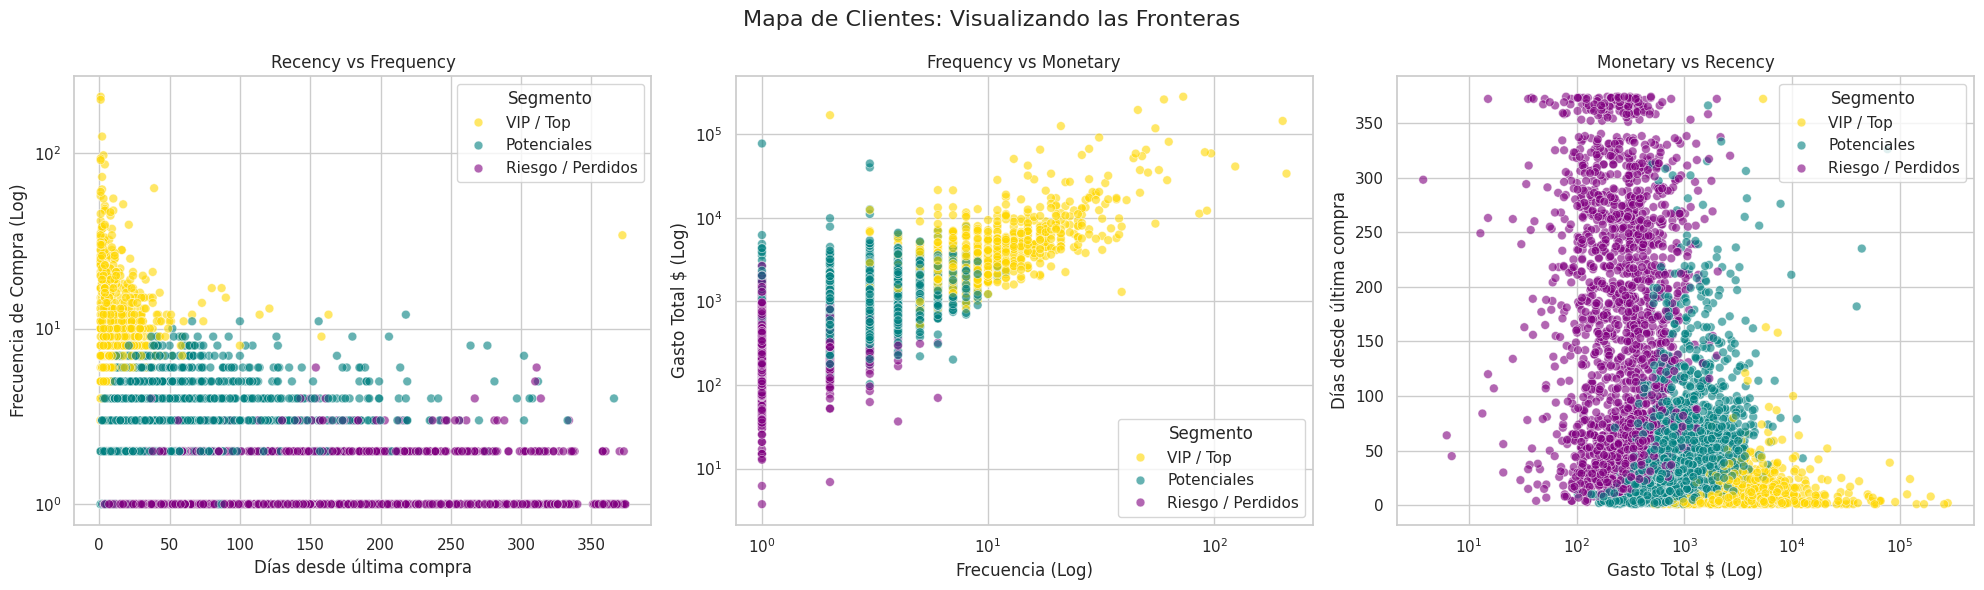

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Parte 7.2: Visualización Bidimensional (Scatter Plots) ---

# Configuración visual
colores = {'VIP / Top': 'gold', 'Potenciales': 'teal', 'Riesgo / Perdidos': 'purple'}
orden_visual = ['VIP / Top', 'Potenciales', 'Riesgo / Perdidos']

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# --- GRÁFICA 1: RECENCY vs FREQUENCY ---
# ¿Quién compra mucho y hace poco tiempo?
sns.scatterplot(x='Recency', y='Frequency', hue='Segmento', data=rfm,
                palette=colores, hue_order=orden_visual, ax=ax[0], alpha=0.6, s=40)
ax[0].set_title('Recency vs Frequency')
ax[0].set_xlabel('Días desde última compra')
ax[0].set_ylabel('Frecuencia de Compra (Log)')
ax[0].set_yscale('log') # Escala Log para ver mejor la separación vertical


# --- GRÁFICA 2: FREQUENCY vs MONETARY ---
# ¿Quién gasta más cuando compra? (Esta es la favorita de Marketing)
sns.scatterplot(x='Frequency', y='Monetary', hue='Segmento', data=rfm,
                palette=colores, hue_order=orden_visual, ax=ax[1], alpha=0.6, s=40)
ax[1].set_title('Frequency vs Monetary')
ax[1].set_xlabel('Frecuencia (Log)')
ax[1].set_ylabel('Gasto Total $ (Log)')
ax[1].set_xscale('log') # Ambas en Log porque crecen exponencialmente
ax[1].set_yscale('log')


# --- GRÁFICA 3: MONETARY vs RECENCY ---
# ¿Los que gastan mucho son recientes?
sns.scatterplot(x='Monetary', y='Recency', hue='Segmento', data=rfm,
                palette=colores, hue_order=orden_visual, ax=ax[2], alpha=0.6, s=40)
ax[2].set_title('Monetary vs Recency')
ax[2].set_xlabel('Gasto Total $ (Log)')
ax[2].set_ylabel('Días desde última compra')
ax[2].set_xscale('log')


plt.suptitle('Mapa de Clientes: Visualizando las Fronteras', fontsize=16)
plt.tight_layout()
plt.show()

Explicación de la Salida:

Al ejecutar este código, verás tres mapas de puntos muy reveladores:

Gráfica Central (Frequency vs Monetary):

Verás una nube de puntos Dorados (VIP) en la esquina superior derecha. Son los que están "arriba y a la derecha" en todo: compran mucho y gastan mucho.

Los Morados (Riesgo) estarán abajo a la izquierda (pocos puntos, poco dinero).

Esta gráfica es perfecta para decir: "Queremos empujar a los puntos Verdes (Potenciales) hacia la zona Dorada".

Gráfica Izquierda (Recency vs Frequency):

Aquí los VIP se pegan a la izquierda (Recency bajo) y suben alto (Frecuencia alta).

Si ves puntos dorados que se empiezan a mover a la derecha (aumenta su Recency), ¡alerta! Son VIPs que se están enfriando.

#Parte 7.3: Visualización Multidimensional Avanzada
Introducción: En esta fase final, dejamos de mirar "puntos" y empezamos a mirar "patrones".

El Snake Plot es vital: si la línea de un grupo está por encima del 0, significa que es superior a la media en esa métrica.

El Heatmap es la herramienta perfecta para el equipo de marketing: les dice exactamente qué mensaje enviar. (Ej: "Este grupo gasta un 300% más que la media").

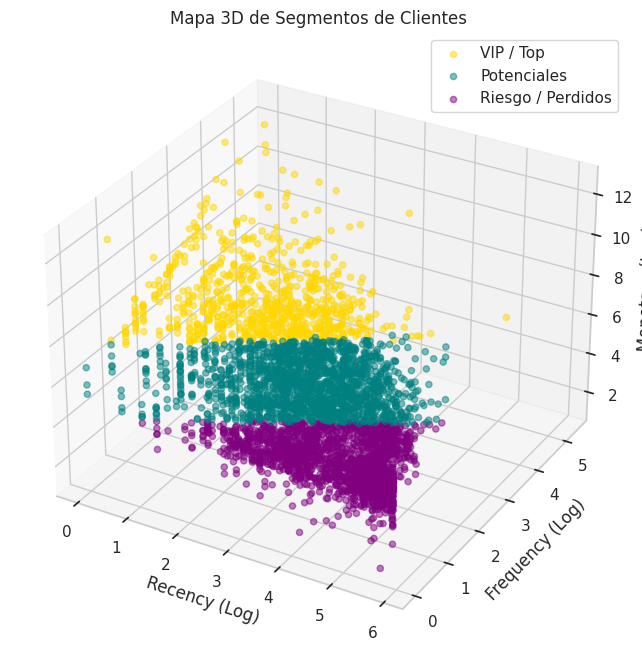

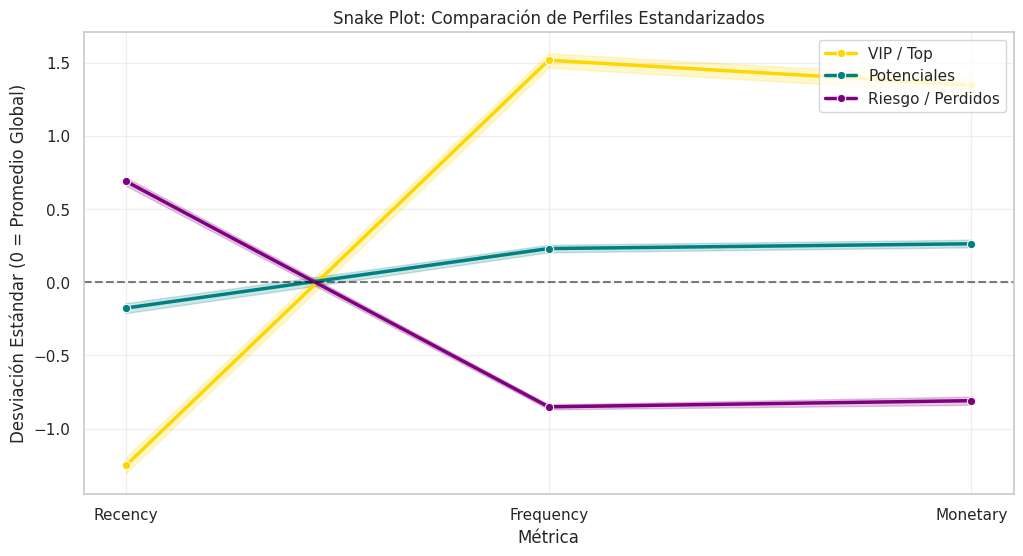

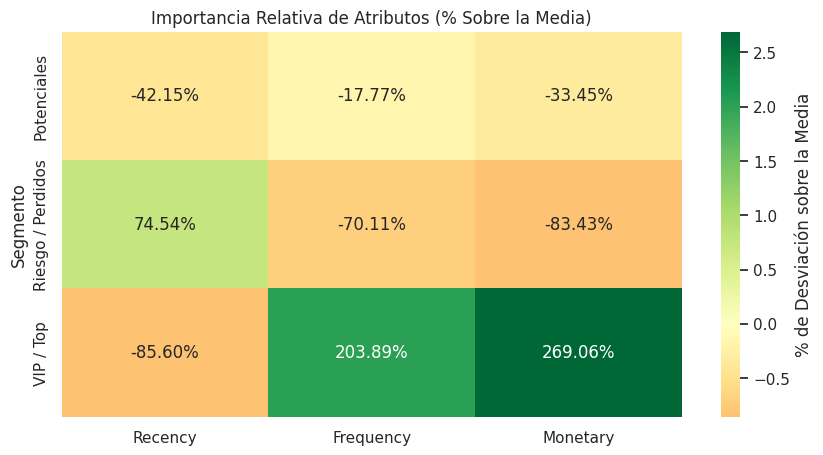

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Parte 7.3: Gráficas Multidimensionales y Estratégicas ---

# Configuración de colores y orden
colores = {'VIP / Top': 'gold', 'Potenciales': 'teal', 'Riesgo / Perdidos': 'purple'}
orden_visual = ['VIP / Top', 'Potenciales', 'Riesgo / Perdidos']

# --- 1. GRÁFICA 3D (La visión espacial) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iteramos por cada segmento para pintarlo de su color
for segmento in orden_visual:
    # Filtramos los datos de ese segmento
    data_segmento = rfm[rfm['Segmento'] == segmento]

    # Pintamos los puntos (Usamos log para que se vea bien la separación)
    ax.scatter(np.log(data_segmento['Recency']),
               np.log(data_segmento['Frequency']),
               np.log(data_segmento['Monetary']),
               c=colores[segmento],
               label=segmento,
               s=20, alpha=0.5)

ax.set_xlabel('Recency (Log)')
ax.set_ylabel('Frequency (Log)')
ax.set_zlabel('Monetary (Log)')
ax.set_title('Mapa 3D de Segmentos de Clientes')
ax.legend()
plt.show()


# --- PREPARACIÓN PARA SNAKE PLOT Y HEATMAP ---
# Necesitamos los datos ESCALADOS (rfm_scaled_df) pero con los nombres de SEGMENTO
# Copiamos el df escalado para no romper nada
rfm_scaled_final = rfm_scaled_df.copy()
rfm_scaled_final['Segmento'] = rfm['Segmento'] # Añadimos la columna de nombres

# Melt (derretir) el dataframe para que sea fácil de graficar con Seaborn
rfm_melted = pd.melt(rfm_scaled_final.reset_index(),
                     id_vars=['CustomerID', 'Segmento'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Métrica', value_name='Valor (Z-Score)')


# --- 2. SNAKE PLOT (Patrones de Comportamiento) ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='Métrica', y='Valor (Z-Score)', hue='Segmento', data=rfm_melted,
             palette=colores, hue_order=orden_visual, marker="o", linewidth=2.5)

plt.title('Snake Plot: Comparación de Perfiles Estandarizados')
plt.xlabel('Métrica')
plt.ylabel('Desviación Estándar (0 = Promedio Global)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5) # Línea de referencia (Promedio)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.show()


# --- 3. HEATMAP DE IMPORTANCIA RELATIVA (La herramienta de Marketing) ---
# Calculamos el promedio de cada segmento
promedio_cluster = rfm.groupby('Segmento')[['Recency', 'Frequency', 'Monetary']].mean()
# Calculamos el promedio global de toda la base de datos
promedio_poblacion = rfm[['Recency', 'Frequency', 'Monetary']].mean()

# Calculamos la importancia relativa: (Promedio Grupo / Promedio Global) - 1
importancia_relativa = (promedio_cluster / promedio_poblacion) - 1

plt.figure(figsize=(10, 5))
sns.heatmap(data=importancia_relativa, annot=True, fmt='.2%',
            cmap='RdYlGn', center=0, cbar_kws={'label': '% de Desviación sobre la Media'})

plt.title('Importancia Relativa de Atributos (% Sobre la Media)')
plt.show()

#Explicación de la Salida :
Gráfica 3D:

Es la "foto bonita" para la portada. Muestra que los grupos están bien separados en el espacio. Los puntos dorados deberían estar en una "esquina" propia.

Snake Plot (Gráfica de Líneas):

Esta es la más técnica. Fíjate en la línea Dorada (VIP):

En Recency, debería bajar picada (porque un valor bajo es bueno en recencia).

En Frequency y Monetary, debería subir como un cohete.

Si ves esto, tu segmentación es perfecta.

Heatmap (Tabla de Colores):

Esta es la que entiende el jefe de ventas.

Si ves un +300% en verde en la casilla de Monetary para los VIPs, significa: "Estos clientes gastan 4 veces más que el usuario normal".

Si ves un +200% en rojo en Recency para Riesgo, significa: "Estos clientes tardan el doble de tiempo en volver que la media".